In [1]:
import time
import talib
import calendar
import datetime
import requests
from config import client_id
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#Takes date entered and returns the epoch time
def date(year, month, day, hour, minute):
    from datetime import date
    import time

    z = int(time.mktime(time.strptime(f'{year}-{month}-{day} {hour}:{minute}', "%Y-%m-%d %H:%M")))
    
    return z

#For some odd reason there needs to be 3 more 0's for the TDAmeritrade api to properly collect this information

#Jan 25th, 2020
start_date = date(2012, 2, 7, 9, 30)
#Gets today's date as an epoch
end_date = calendar.timegm(time.gmtime())

In [2]:
def get_priceHistory(start_date, end_date, symbol):
    
    #Multiply epoch date to add 3 extra zero's
    start_date, end_date = start_date*1000, end_date*1000
    
    payload = {
    'apikey':client_id,
    }


    #endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?\
    #periodType=month&frequencyType=daily&needExtendedHoursData=true&frequency=1&startDate={start_Date}&endDate={end_Date}'
    
    endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?periodType=month\
    &frequencyType=daily&startDate={start_date}&endDate={end_date}'

    content = requests.get(url = endpoint, params = payload)

    data = content.json()
    
    #The columns on my dataframe
    my_columns = ['datetime', 'open','high', 'low','close','volume']

    dataframe = pd.DataFrame(columns = my_columns)

    #Creating a dictionary of lists
    fields = {key: [] for key in my_columns}

    #Iterates through the keys in the fields dictionary
    #Date is arranged as (Year-Month-Day)
    for key in fields:
        datetime_key = key
        if datetime_key == 'datetime':
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                epochtime = fields['datetime'][i]

                #time_formatted = datetime.datetime.fromtimestamp(epochtime/1000)

                #time_formatted = time.strftime(time.localtime(epochtime/1000))

                time_formatted = time.strftime('%Y-%m-%d %H:%M', time.localtime(epochtime/1000))
                #time_formatted = time.strftime('%Y-%m-%d', time.localtime(epochtime/1000))
                #time_formatted = time.strftime('%Y-%m-%d', time.localtime(epochtime/1000))

                #time_formatted = time.strftime("%A, %D %B %Y %H:%M:%S + 0000", time.gmtime(epochtime/1000))

                fields[f'{key}'][i] = time_formatted 
        else:
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                
    #Appends to the dataframe the dictionary of lists('fields')
    dataframe = pd.DataFrame(fields)
    
    #Adds the ticker symbol at front of the dataframe
    dataframe.insert(loc=0, column='Ticker', value=f'{symbol.upper()}')

    #Changes date into datetime object
    dataframe['datetime'] =  pd.to_datetime(dataframe['datetime'], infer_datetime_format=True)
    
    #Features
    #dataframe['Move_avg25'] = talib.MA(dataframe['close'], timeperiod=25, matype=0)
    #dataframe['Move_avg50'] = talib.MA(dataframe['close'], timeperiod=50, matype=0)
    #dataframe['SMA_25'] = talib.SMA(dataframe['close'], timeperiod=25)
    #dataframe['EMA_25'] = talib.EMA(dataframe['close'], timeperiod=25)

    return dataframe

In [3]:
df_msft = get_priceHistory(start_date, end_date, 'MSFT')
df_aapl = get_priceHistory(start_date, end_date, 'aapl')

In [4]:
df_msft

,Ticker,datetime,open,high,low,close,volume
0,MSFT,2012-02-07 01:00:00,30.15,30.485,30.05,30.3500,39242529
1,MSFT,2012-02-08 01:00:00,30.26,30.670,30.22,30.6600,49662740
2,MSFT,2012-02-09 01:00:00,30.68,30.800,30.48,30.7700,50481549
3,MSFT,2012-02-10 01:00:00,30.64,30.800,30.36,30.4950,44606751
4,MSFT,2012-02-13 01:00:00,30.63,30.770,30.43,30.5800,33322516
...,...,...,...,...,...,...,...
2553,MSFT,2022-03-30 01:00:00,313.76,315.950,311.58,313.8600,28163555
2554,MSFT,2022-03-31 01:00:00,313.90,315.140,307.89,308.3100,33422070
2555,MSFT,2022-04-01 01:00:00,309.37,310.130,305.54,309.4200,27110529
2556,MSFT,2022-04-04 01:00:00,310.09,315.110,309.71,314.9700,24335868


In [5]:
out = pd.concat([df_msft, df_aapl], keys=['MSFT', 'AAPL']).droplevel(1) \
        .rename_axis('symbol').set_index('datetime', append=True) \
        .swaplevel().sort_index()
out2 = pd.DataFrame(out)

In [6]:
#Making a 'features' dataframe which will contain the features of the stocks in question
features = pd.DataFrame(index=df_msft.datetime).sort_index()

In [7]:
features

""
datetime
2012-02-07 01:00:00
2012-02-08 01:00:00
2012-02-09 01:00:00
2012-02-10 01:00:00
2012-02-13 01:00:00
...
2022-03-30 01:00:00
2022-03-31 01:00:00
2022-04-01 01:00:00


In [8]:
features = pd.DataFrame(index=df_msft.index).sort_index()

In [9]:
features

""
0
1
2
3
4
...
2553
2554
2555
2556


In [10]:
#These will be the values for the groups
#features['daily_change'] = (df_msft.close/df_msft.open-1).values # daily return
#features['pct_change_on_day'] = (df_msft.open/df_msft.close.shift(1)-1).values

In [11]:
features

""
0
1
2
3
4
...
2553
2554
2555
2556


#Smooth out the distrbution to allow the algo to better make a function
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(df_msft, 0.65)
#Locates the last 60 days for graphing
tmp1 = data.iloc[-60:]
tmp1['close'].plot()

rsi = talib.RSI(df_msft['close'], timeperiod=14)
features['RSI'] = rsi

features.head(20)

#function for returning a dataframe filled with indicators and features

macd, macdsignal, macdhist = talib.MACD(df_msft['close'], fastperiod=12, slowperiod=26, signalperiod=9)

slowk, slowd = talib.STOCH(df_msft['high'], df_msft['low'], df_msft['close'], 
                     fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

real = talib.ATR(df_msft['high'], df_msft['low'], df_msft['close'], timeperiod=14)



In [12]:
#For getting the n_day regression coefficient
from sklearn.linear_model import LinearRegression

def linear_regression(x, y):
    """
    performs linear regression given x and y. outputs regression coefficient
    """
    #fit linear regression
    lr = LinearRegression()
    lr.fit(x, y)
    
    return lr.coef_[0][0]

#Takes n days, dataframe, and features dataframe
def n_day_regression(n, df, features_df):
    """
    n day regression.
    """
    #variable
    _varname_ = f'{n}_reg'
    features_df[_varname_] = np.nan

    idxs = np.arange(0, len(df))
    for idx in idxs:
        if idx > n:
            
            y = df['close'][idx - n: idx].to_numpy()
            x = np.arange(0, n)
            #reshape
            y = y.reshape(y.shape[0], 1)
            x = x.reshape(x.shape[0], 1)
            #calculate regression coefficient 
            coef = linear_regression(x, y)
            features_df.loc[idx, _varname_] = coef #add the new value
            
    return features_df

#how to use loc, .loc[what rows you want, what columns you want]
df_msft.loc[1, 'open']

## Features

In [13]:
# numbers close to 1 indicate a the stock closed near the HIGH of the day, 
# while lower numbers indicate the closing near the LOW of the day

# change from open today from open yesterday
#features['pct_change(not_in_%)'] = (df_msft.open/df_msft.open.shift(1)-1).values

# log of daily volume
#features['Log_volume'] = df_msft.volume.apply(np.log) 

n_day_regression(5, df_msft, features)
n_day_regression(10, df_msft, features)
n_day_regression(20, df_msft, features)

#Kind of standardizes the information on tick data, but maybe peeks into the future
#features['Norm_prices'] = (df_msft.close-df_msft.low)/(df_msft.high - df_msft.low)
#features['MA_9'] = df_msft.close.rolling(9).mean()
features

,5_reg,10_reg,20_reg
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2553,3.844,1.963879,1.305008
2554,3.125,2.022970,1.678759
2555,1.242,1.598667,1.885248
2556,-0.966,1.423576,1.993278


In [14]:
features.head(50)

,5_reg,10_reg,20_reg
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,-0.1010,NaN,NaN
7,-0.1685,NaN,NaN
8,0.1050,NaN,NaN
9,0.2375,NaN,NaN


.rolling(n) .mean()

Where n is the number back that is doing the math, in this case it will do the mean of n spaces back

In [15]:
features.head(15)

,5_reg,10_reg,20_reg
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,-0.1010,NaN,NaN
7,-0.1685,NaN,NaN
8,0.1050,NaN,NaN
9,0.2375,NaN,NaN


In [16]:
features = features.dropna()

In [17]:
features

,5_reg,10_reg,20_reg
21,-0.1420,0.049515,0.088150
22,-0.0090,0.039939,0.089060
23,0.0835,0.028848,0.089391
24,0.1120,0.005636,0.084259
25,0.1690,0.043091,0.087147
...,...,...,...
2553,3.8440,1.963879,1.305008
2554,3.1250,2.022970,1.678759
2555,1.2420,1.598667,1.885248
2556,-0.9660,1.423576,1.993278


In [18]:
df_msft_reindexed = df_msft.reindex(features.index)

In [19]:
df_msft_reindexed

,Ticker,datetime,open,high,low,close,volume
21,MSFT,2012-03-08 01:00:00,32.04,32.210,31.90,32.0100,36752011
22,MSFT,2012-03-09 01:00:00,32.10,32.160,31.92,31.9900,34628398
23,MSFT,2012-03-12 01:00:00,31.97,32.200,31.82,32.0400,34076755
24,MSFT,2012-03-13 01:00:00,32.24,32.690,32.15,32.6700,48951650
25,MSFT,2012-03-14 01:00:00,32.53,32.880,32.49,32.7700,41987743
...,...,...,...,...,...,...,...
2553,MSFT,2022-03-30 01:00:00,313.76,315.950,311.58,313.8600,28163555
2554,MSFT,2022-03-31 01:00:00,313.90,315.140,307.89,308.3100,33422070
2555,MSFT,2022-04-01 01:00:00,309.37,310.130,305.54,309.4200,27110529
2556,MSFT,2022-04-04 01:00:00,310.09,315.110,309.71,314.9700,24335868


## Walk Forward Optimization

### Non Walk forward first

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X=features,y=df_msft_reindexed['open'])
print('RSQ: '+str(model.score(X=features,y=df_msft_reindexed['open'])))
print('Regression Coefficients: '+str(model.coef_))

RSQ: 0.05079189732580347
Regression Coefficients: [ 4.52212857  1.11842238 36.33333974]


In [21]:
split_point = int(0.80*len(df_msft_reindexed['open']))

X_train = features.iloc[:split_point,:] 
y_train = df_msft_reindexed['open'].iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = df_msft_reindexed['open'].iloc[split_point:] 

model = LinearRegression()
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(model.score(X=X_train,y=y_train)))
print('RSQ out of sample: '+str(model.score(X=X_test,y=y_test)))
print('Regression Coefficients: '+str(model.coef_))

RSQ in sample: 0.039590415789267586
RSQ out of sample: -13.717356486540542
Regression Coefficients: [ 4.81606237 -4.0528944  27.92526878]


### Reindexing the features columns with the date

In [22]:
features = features.set_index(df_msft_reindexed['datetime'])

In [23]:
features

,5_reg,10_reg,20_reg
datetime,,,
2012-03-08 01:00:00,-0.1420,0.049515,0.088150
2012-03-09 01:00:00,-0.0090,0.039939,0.089060
2012-03-12 01:00:00,0.0835,0.028848,0.089391
2012-03-13 01:00:00,0.1120,0.005636,0.084259
2012-03-14 01:00:00,0.1690,0.043091,0.087147
...,...,...,...
2022-03-30 01:00:00,3.8440,1.963879,1.305008
2022-03-31 01:00:00,3.1250,2.022970,1.678759
2022-04-01 01:00:00,1.2420,1.598667,1.885248


In [ ]:
df_msft_reindexed = df_msft.reindex(features.index) 

In [26]:
recalc_dates = features.resample('M', level='datetime' ).mean().index.values[:-1]
print('recalc_dates:')
print(recalc_dates)
print()



recalc_dates:
['2012-03-31T00:00:00.000000000' '2012-04-30T00:00:00.000000000'
 '2012-05-31T00:00:00.000000000' '2012-06-30T00:00:00.000000000'
 '2012-07-31T00:00:00.000000000' '2012-08-31T00:00:00.000000000'
 '2012-09-30T00:00:00.000000000' '2012-10-31T00:00:00.000000000'
 '2012-11-30T00:00:00.000000000' '2012-12-31T00:00:00.000000000'
 '2013-01-31T00:00:00.000000000' '2013-02-28T00:00:00.000000000'
 '2013-03-31T00:00:00.000000000' '2013-04-30T00:00:00.000000000'
 '2013-05-31T00:00:00.000000000' '2013-06-30T00:00:00.000000000'
 '2013-07-31T00:00:00.000000000' '2013-08-31T00:00:00.000000000'
 '2013-09-30T00:00:00.000000000' '2013-10-31T00:00:00.000000000'
 '2013-11-30T00:00:00.000000000' '2013-12-31T00:00:00.000000000'
 '2014-01-31T00:00:00.000000000' '2014-02-28T00:00:00.000000000'
 '2014-03-31T00:00:00.000000000' '2014-04-30T00:00:00.000000000'
 '2014-05-31T00:00:00.000000000' '2014-06-30T00:00:00.000000000'
 '2014-07-31T00:00:00.000000000' '2014-08-31T00:00:00.000000000'
 '2014-09-3

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='datetime',drop_level=False)
    y_train = df_msft_reindexed_date.xs(slice(None,date),level='datetime',drop_level=False)
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    
    print("Training on the first {} records, through {}"\
          .format(len(y_train),y_train.index.get_level_values('date').max()))
    #print("Coefficients: {}".format((model.coef_)))
    #print()

.xs function is for multi indexs where multiple tickers will be taking up the spot

In my case i need to split it based on the on stock

In [27]:
models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.loc[None:date, ]
    y_train = df_msft_reindexed_date.loc[None:date, 'close']
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    
    print("Training on the first {} records, through {}"\
          .format(len(y_train),y_train.index.get_level_values('datetime').max()))
    #print("Coefficients: {}".format((model.coef_)))
    #print()

Training on the first 17 records, through 2012-03-30 01:00:00
Training on the first 36 records, through 2012-04-27 01:00:00
Training on the first 58 records, through 2012-05-30 01:00:00
Training on the first 80 records, through 2012-06-29 01:00:00
Training on the first 100 records, through 2012-07-30 01:00:00
Training on the first 123 records, through 2012-08-30 01:00:00
Training on the first 143 records, through 2012-09-28 01:00:00
Training on the first 163 records, through 2012-10-26 01:00:00
Training on the first 184 records, through 2012-11-29 01:00:00
Training on the first 204 records, through 2012-12-28 01:00:00
Training on the first 225 records, through 2013-01-30 01:00:00
Training on the first 244 records, through 2013-02-27 01:00:00
Training on the first 265 records, through 2013-03-28 01:00:00
Training on the first 286 records, through 2013-04-29 01:00:00
Training on the first 308 records, through 2013-05-30 01:00:00
Training on the first 329 records, through 2013-06-28 01:00

C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/4207680625.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models = pd.Series(index=recalc_dates)


<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

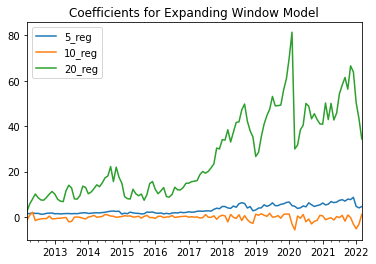

In [28]:
def extract_coefs(models):
    coefs = pd.DataFrame()
    for i,model in enumerate(models):
        model_coefs = pd.Series(model.coef_,index=features.columns) #extract coefficients for model
        model_coefs.name = models.index[i] # name it with the recalc date
        coefs = pd.concat([coefs,model_coefs],axis=1)
    return coefs.T

extract_coefs(models).plot(title='Coefficients for Expanding Window Model')



In [29]:
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = features.loc[begin_dates[i]:end_dates[i]]
    p = pd.Series(model.predict(X),index=X.index)
    predictions.loc[X.index] = p

predictions.shape


C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/3204183226.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=features.index)


(2537,)

In [32]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression

def make_walkforward_model(features,y_variable,algo=LinearRegression()):
    recalc_dates = features.resample('Q', level='datetime' ).mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.loc[None:date, ]
        y_train = df_msft_reindexed_date.loc[None:date, 'close']
        #print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2022-4-30']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
        #print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.loc[begin_dates[i]:end_dates[i]]
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

linear_models,linear_preds = make_walkforward_model(features,df_msft_reindexed_date['close'],algo=LinearRegression())
tree_models,tree_preds = make_walkforward_model(features,df_msft_reindexed_date['close'],algo=ExtraTreesRegressor())

C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/1233804391.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models = pd.Series(index=recalc_dates)
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/1233804391.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=features.index)
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/1233804391.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models = pd.Series(index=recalc_dates)
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/1233804391.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

In [34]:
print("Models:")
print(linear_models.head())
print()
print("Predictions:")
print(linear_preds.dropna().head())

Models:
2012-03-31    LinearRegression()
2012-06-30    LinearRegression()
2012-09-30    LinearRegression()
2012-12-31    LinearRegression()
2013-03-31    LinearRegression()
dtype: object

Predictions:
datetime
2012-04-02 01:00:00    31.977408
2012-04-03 01:00:00    32.053052
2012-04-04 01:00:00    32.064189
2012-04-05 01:00:00    31.849725
2012-04-09 01:00:00    31.813636
dtype: float64


<AxesSubplot:title={'center':'Weighting Coefficients for \nLinear Model'}>

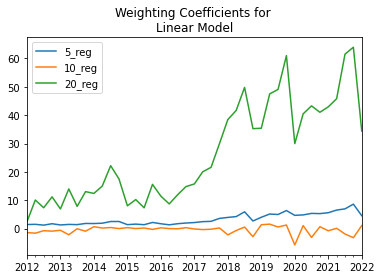

In [35]:
pd.DataFrame([model.coef_ for model in linear_models],
             columns=X.columns,index=linear_models.index).plot(title='Weighting Coefficients for \nLinear Model')

In [36]:
from sklearn.metrics import r2_score,mean_absolute_error

def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1).dropna()

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['RSQ'] = r2_score(df.y_true,df.y_pred)
    scorecard.loc['MAE'] = mean_absolute_error(df.y_true,df.y_pred)
    scorecard.loc['directional_accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    # derived metrics
    scorecard.loc['edge_to_noise'] = scorecard.loc['edge'] / scorecard.loc['noise']
    scorecard.loc['edge_to_mae'] = scorecard.loc['edge'] / scorecard.loc['MAE']
    return scorecard    

calc_scorecard(y_pred=linear_preds,y_true=df_msft_reindexed_date['close']).rename('Linear')

C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/284676119.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scorecard = pd.Series()


RSQ                      -0.031291
MAE                      53.716787
directional_accuracy     98.888889
edge                    100.286164
noise                     2.796884
edge_to_noise            35.856386
edge_to_mae               1.866943
Name: Linear, dtype: float64

datetime              2020-12-31  2021-12-31  2022-12-31
RSQ                   -29.185936  -21.964495 -473.272296
MAE                   118.996080  170.206848  247.891863
directional_accuracy   93.280632  100.000000   83.076923
edge                  172.806601  275.940774  200.566971
noise                   7.591658    8.090830   19.403629
edge_to_noise          22.762696   34.105374   10.336570
edge_to_mae             1.452204    1.621208    0.809091


C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/284676119.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scorecard = pd.Series()
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/284676119.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scorecard = pd.Series()
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/284676119.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scorecard = pd.Series()
C:\Users\pauln\AppData\Local\Temp/ipykernel_14308/284676119.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

<AxesSubplot:title={'center':'Prediction Edge vs. MAE'}, xlabel='datetime'>

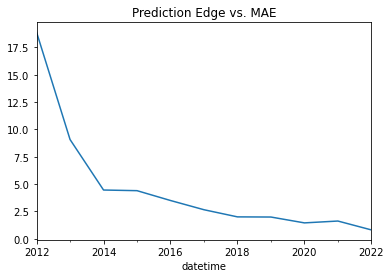

In [37]:
def scores_over_time(y_pred,y_true):
    df = pd.concat([y_pred,y_true],axis=1).dropna().reset_index().set_index('datetime')
    scores = df.resample('A').apply(lambda df: calc_scorecard(df[y_pred.name],df[y_true.name]))
    return scores

scores_by_year = scores_over_time(y_pred=linear_preds,y_true=df_msft_reindexed_date['close'])
print(scores_by_year.tail(3).T)
scores_by_year['edge_to_mae'].plot(title='Prediction Edge vs. MAE')

In [38]:
from sklearn.linear_model import LassoCV
def prepare_Xy(X_raw,y_raw):
    ''' Utility function to drop any samples without both valid X and y values'''
    Xy = X_raw.join(y_raw).replace({np.inf:None,-np.inf:None}).dropna()
    X = Xy.iloc[:,:-1]
    y = Xy.iloc[:,-1]
    return X,y
X_ens, y_ens = prepare_Xy(X_raw=pd.concat([linear_preds.rename('linear'),tree_preds.rename('tree')],
                                          axis=1),y_raw=y)

ensemble_models,ensemble_preds = make_walkforward_model(X_ens,y_ens,algo=LassoCV(positive=True))
ensemble_preds = ensemble_preds.rename('ensemble')
print(ensemble_preds.dropna().head())

NameError: name 'y' is not defined